## This is supposed to be a summary of the results I've obtained so far

As initially proposed, tables were constructed in such a way that two elements X,Y appear in the same table only if there exist 2 compounds $A = R-X_n$ and $B = R-Y_n$, where if X were replaced by Y in compound A, the result would be compound B. This approximation ignores every structural factor and relies only in compositional data.

Note from this approach that n is an integer, that is, there's a problem when treating non-stoichiometric compounds. In the given dataset there are actually examples of such non-stoichiometric compounds, and so this case had to be handled properly.

- Solution: If upon duplication of all ns in the given compound, this compound is stoichiometric, then work with this, otherwise discard the compound. All compunds that weren't used in this analysis due to this are stored under the `out.log` file, which corresponds to the output of the `MPIgetTabs.py` script used for the aforementioned data preprocessing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from getElems import getElems
from TPs import TP
import seaborn as sns; sns.set() ; sns.set_style('white')
import pandas as pd

## Load all the data that was produced with MPIgetTabs.py using dataset sample.csv

Both tables and correspondent compounds were saved in 3 different files each (due to the parallel implementation of `MPIgetTabs.py`. The files `R_Tables_Pi.npy` correspond to the tables while `R_Vector_Pi.npy` correspond to the molecular fragment `R` left upon removal of $X_n$ from the respective compounds. This way we can reconstruct the whole (used) dataset after preprocessing.

In [2]:
t1 = np.load("Data/R_Tables_P0.npy")
t2 = np.load("Data/R_Tables_P1.npy")
t3 = np.load("Data/R_Tables_P2.npy")

t = np.concatenate([t1,t2,t3],axis=0)
print(t.shape)

r1 = np.load("Data/R_Vector_P0.npy")
r2 = np.load("Data/R_Vector_P1.npy")
r3 = np.load("Data/R_Vector_P2.npy")
r = np.concatenate([r1,r2,r3],axis=0)
print(r.shape)

elemList = getElems("sample.csv",12000)
print(elemList[:10])

(6145, 7, 32)
(6145, 61)
['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C']


### Visualize some of the resulting tables including formulas

- Purple means there exist no element in this position

- Blue means the element exist but the compound in question does not exist

- Yellow means the compound R-X (X being the yellow element) exists

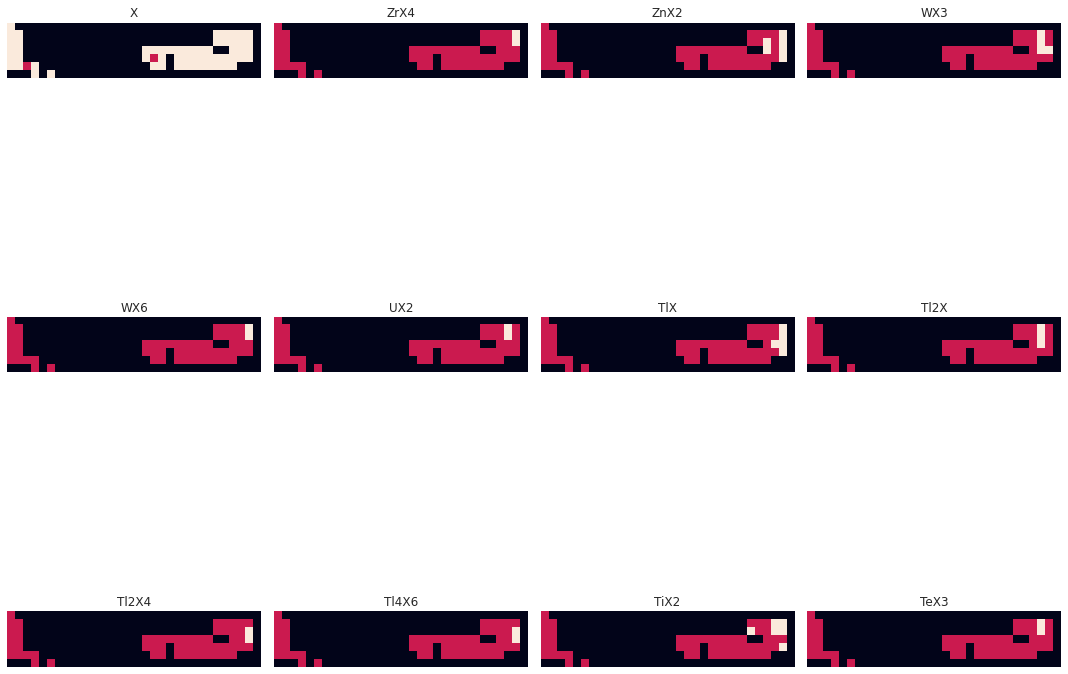

In [3]:
def getFormula(R,elemList):
    """Convert R vector into string composition:
    [0,1,0,...,4,6] --> Ti4X6 for instance """
    
    form = ''
    for i in np.nonzero(R[:-1])[0]:
        form += elemList[i] 
        if R[i] != 1:
            form += str(int(R[i]))
    return form + f'X{int(R[-1]) if R[-1]!=1 else ""}'


N = 3
fig = plt.figure(figsize=(15,5*N))
for i in range(4*N):
    ax = fig.add_subplot(N,4,i+1)
    ax.set_title(getFormula(r[i],elemList))
    ax.imshow(t[i])
    ax.axis('off')
plt.tight_layout()

---
## Most of the positions where Lantanides and Actinides are located in PT are blank.

I'll strip some of the purple positions where no information is found (most of lanthanides and actinides hadn't been discovered, plus noble gases did not involve in compounds to this date)

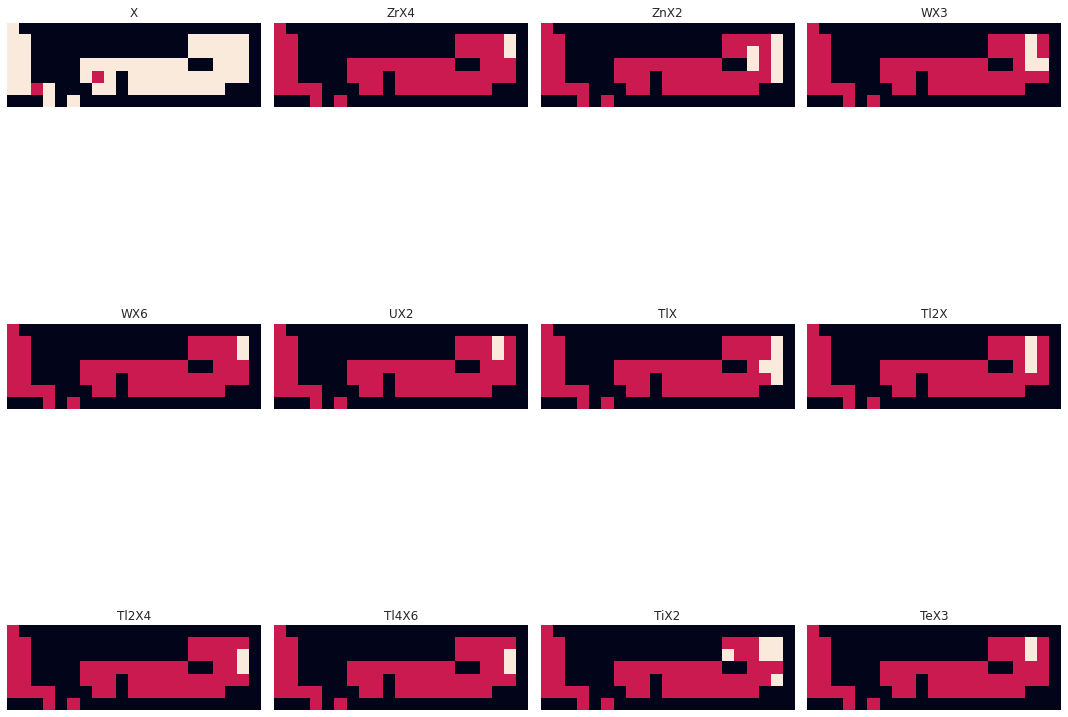

In [4]:
c1 = 6  # Remove from columns 6 to 17
c2 = 17

a1 = t[:,:,:c1] 
a2 = t[:,:,c2:]
a = np.concatenate([a1,a2],axis=2)

# Redefine PT to account for this change
rTP = {}
for i in TP.keys():
    crds = TP[i]
    # If column index is changed(after c1 all is changed), then substract diff to account for this
    if crds[1] >= c2:  rTP[i] = (crds[0],crds[1] - (c2-c1)) 
    # If element was removed (bc didn't exist) then don't add it to new PT
    elif crds[1] >=c1: pass
    else:              rTP[i] = crds

N = 3
fig = plt.figure(figsize=(15,5*N))
for i in range(4*N):
    ax = fig.add_subplot(N,4,i+1)
    ax.set_title(getFormula(r[i],elemList))
    ax.imshow(a[i,:,:])
    ax.axis('off')
plt.tight_layout()

## Blue color is in principle just for visualization. Now I'll remove them.

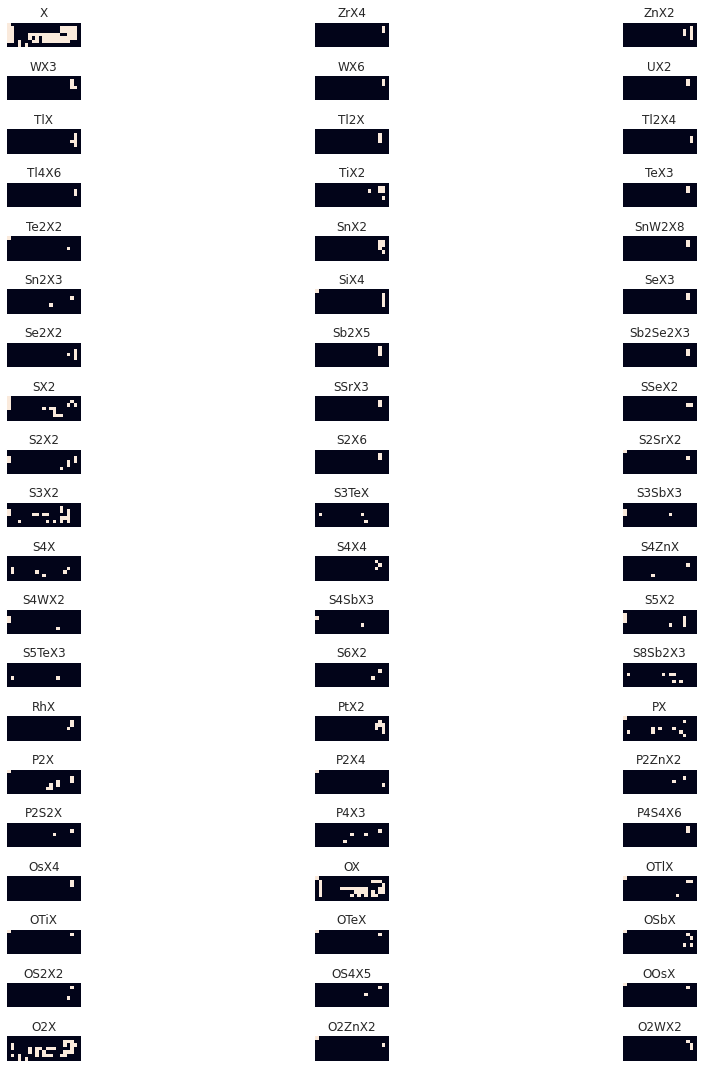

In [5]:
T = (a==1)*1

N = 3 
fig = plt.figure(figsize=(15,5*N))
for i in range(N*20):
    ax = fig.add_subplot(20,N,i+1)
    ax.set_title(getFormula(r[i],elemList))
    ax.imshow(T[i,:,:])
    ax.axis('off')
plt.tight_layout()

### This new T tensor contains only information about the elements X for which the compound R-X$_n$ exists (and their position in PT)

## Calculate some descriptive statistics on the data obtained:

- Mean vertical, horizontal, and euclidean distance between elements in a same table. For a "good" periodic system all these quantities are expected to be minimum.

In [6]:
def meanDist(dt):
    Vert = dt.copy()*0.
    Horiz = dt.copy()*0.
    Euclid = dt.copy()*0.
    norm = dt.copy()*0.
    
    for exam in range(dt.shape[0]):    #For each table in DS
        ys,xs = np.nonzero(dt[exam]==1)  #Determ. which entries correspond to a positive

        for ex,ey in zip(xs,ys):        #Calc distance from each positive element in this table
            for i in range(xs.shape[0]):   #Loop through all other elements

                Vert[exam,ey,ex] += abs(ey - ys[i]) /6  #Calc vert distance
                Horiz[exam,ey,ex] += abs(ex - xs[i])/20  #Calc horiz distance
                Euclid[exam,ey,ex] += np.sqrt(((ey - ys[i])/6)**2 + ((ex - xs[i])/20)**2)   #Calc euclid distance
                
                norm[exam,ey,ex] += 1
         
    with np.errstate(invalid='ignore'):
        Vert /= norm
        Horiz /= norm
        Euclid /= norm
    return Vert,Horiz,Euclid,norm


def makeBoxPlot(dt,TP):
    """ Use redefined PT, so that it matches with dt dimensions"""
    names = []  #Will be the names of df columns. Will appear in the box's labels
    inv_PT = {v: k for k, v in TP.items()}  #Inverted map (positions -> element name)
    for y in range(dt.shape[1]):
        for x in range(dt.shape[2]):         
            key = (y,x)
            if key in inv_PT.keys():     names.append(inv_PT[key])  #Return element at this position
            else:                        names.append('None')       #If no element, return None
    
    dt = pd.DataFrame(dt.reshape(dt.shape[0],-1),columns=names)  #Reshape into [N_Tables, TPdims] DF
    dt = dt.dropna(axis=1,how='all')    #Select only entries for which elements exist (non-nan)
    fig,ax = plt.subplots(figsize=(18,5))
    
    sns.boxplot(data=dt,ax=ax)#,saturation=1,fliersize=4)
    plt.show()
    
def makeTPPlot(dt,norm,title="Mean Euclidean Distance"):
    with np.errstate(invalid='ignore'):
        dt = np.nan_to_num(dt*norm).sum(axis=0)/norm.sum(axis=0)
    fig,ax = plt.subplots(figsize=(18,5))
    ax.set_title(title,fontsize=20)
    mapable = ax.imshow(dt)
    fig.colorbar(mapable)

    ax.axis('off')
    plt.show()

In [7]:
#%%timeit -n 10
#
#vert,horiz,eucl,norm = meanDist(T)
#
#615 ms ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

## The plots below show different mean distances from one element to the others in the same table.

- For instance, if one table contains only H and Na, then Horizontal distance = 0 (as they are located in the same group), Vertical distance = 2 (as Na is 2 periods above H) and euclidean distance is = 2 as well.

We do this for each element present in each table and calculate a mean among tables.

The PT plots should be self-explanatory, however the boxplots are made so that also other quantities such as median and outliers are visualized.

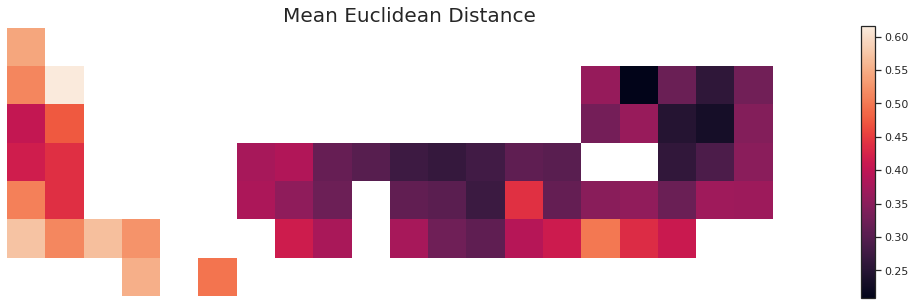

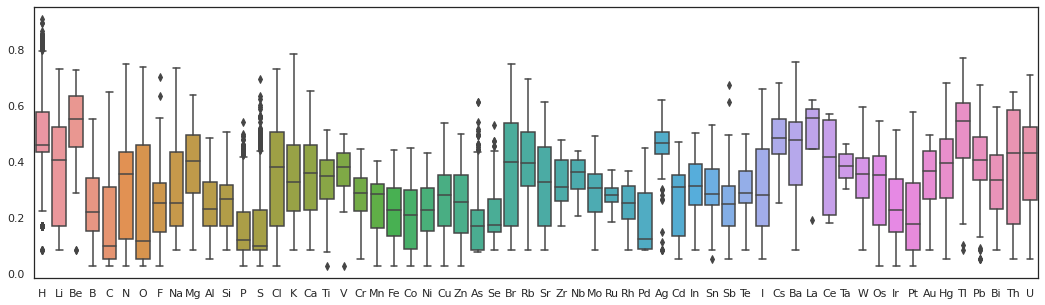

In [8]:
vert,horiz,eucl,norm = meanDist(T)

makeTPPlot(eucl,norm,title="Mean Euclidean Distance")
makeBoxPlot(eucl,rTP)

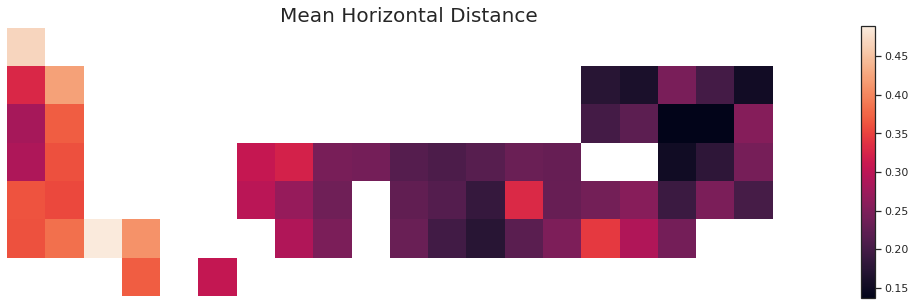

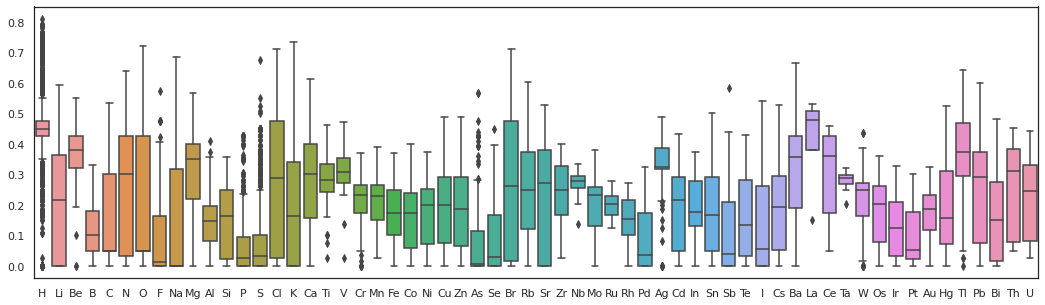

In [9]:
makeTPPlot(horiz,norm,title="Mean Horizontal Distance")
makeBoxPlot(horiz,rTP)

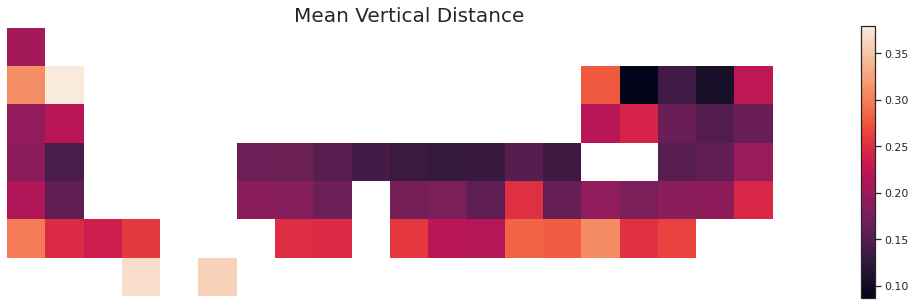

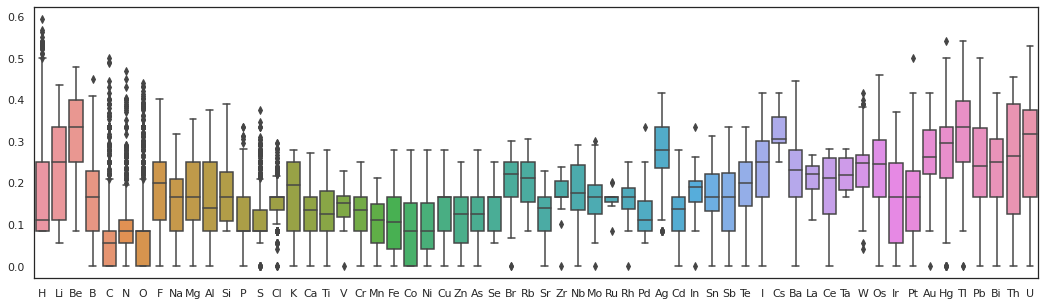

In [10]:
makeTPPlot(vert,norm,title="Mean Vertical Distance")
makeBoxPlot(vert,rTP)

## For me the most significant measure of 'fitness' of a PT is Horizontal distance.

This variable measures by what amount are similar elements in nearby columns, which is pretty much the idea of the original periodic table. 

The other measures are not in principle so important as vertical separation is mainly defined by order relationships, that is, as much as H is similar to Cs, Cs's atomic mass is much greater than H's.

## Plot means as a lineplot, so we can see if there is some trend.

In [11]:
vert,horiz,eucl,norm = meanDist(T)

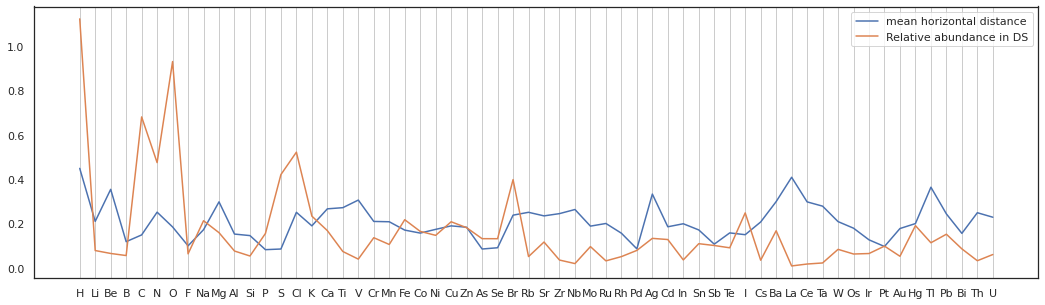

In [12]:
dt = horiz

######
#  This 'names' list will be useful as it contains: symbol of element if element exists, else None.
######

names = []  #Will be the names of df columns. Will appear in the box's labels
inv_PT = {v: k for k, v in rTP.items()}  #Inverted map (positions -> element name)
for y in range(dt.shape[1]):
    for x in range(dt.shape[2]):         
        key = (y,x)
        if key in inv_PT.keys():     names.append(inv_PT[key])  #Return element at this position
        else:                        names.append('None')       #If no element, return None
    
dt = (pd.DataFrame(dt.reshape(dt.shape[0],-1),
                   columns=names)
      .dropna(how='all',axis=1))


dt2 = norm.sum(axis=0)/norm.sum()

dt2 = (pd.DataFrame(dt2.reshape(1,-1),
                   columns=names)
      .replace(0.,np.nan)
      .dropna(how='all',axis=1))


fig,ax = plt.subplots(figsize=(18,5))

sns.lineplot(data=dt.mean(),ax=ax,label='mean horizontal distance')
sns.lineplot(data=dt2.mean()*10,ax=ax,label='Relative abundance in DS')
ax.grid(axis='x')
plt.show()

## Optional: Try to implement an algorithm for optimization of certain metrics (for instance Horizontal distance). Variation of positions of elements to decrease distance, while conserving massic order.

- Genetic algorithms for instance

Use this optimised PS as a comparison when implementing CNN.

--- 
## Let's now see what are the 'most similar' elements for each element.
 That is, find what elements share the most molecular fragments with a given element.

In [13]:
from matplotlib.gridspec import GridSpec

def mostSimElems(element):
    """Plot a map and a barplot of the most similar elements for the given element
    based on 'replaceability' in chemical formulas"""

    x,y = rTP[element]
    img = T[T[:,x,y]==1].sum(axis=0).copy()

    mask = img!=0
    with np.errstate(invalid='ignore',divide='ignore'):
        img = img/mask  #Convert zeros to NaNs so image only shows elements
        img[x,y] = np.nan   #Don't plot element, only every other element

    
    df = (pd.DataFrame(img.reshape(1,-1),
                   columns=names)
      .dropna(how='all',axis=1))   # Flatten img and drop 'NaN' entries for barplot
    
    
    fig = plt.figure(figsize=(15,8))
    gs = fig.add_gridspec(2,2,  width_ratios=(15, 1), height_ratios=(5, 4),
                  #    left=0, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

    ax = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, :])
    cbar = fig.add_subplot(gs[0,1])
    
    mapable = ax.imshow(img)
    fig.colorbar(mapable,ax=cbar)
    ax.set_title(f'Replaceability of {element} in chemical formulas', fontsize=20)
    
    ax.axis('off')
    cbar.axis('off')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    sns.barplot(data=df,ax=ax1);
    
    # Put the element's symbol at it's position
    if len(element)==1:  tab = 0.19
    else:                tab = 0.37
    ax.text(y-tab,x+0.15,element,fontsize=20)    
    
    return df

## Let's make these plots for some elements and see what's interesting

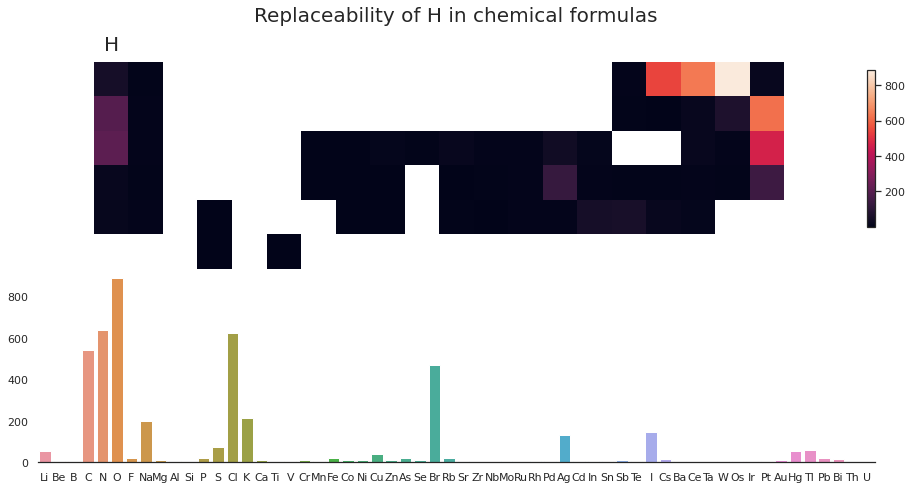

In [14]:
_ = mostSimElems('H')

### There are some interesting results we can further explore here:

For instance, in the H plot we see: 
- The most 'similar' elements are the halogens (except F) 
- and the first period of the p-block elements (C,N,O)
- Others like alkaline metals have much lower counts, while this would be expected for them to be higher (as H is in group 1).

#### Let's explore which compounds in particular are responsible for such a behaviour.

In [15]:
def showCommonOccurences(elem1,elem2,maxNum):
    """Show which compounds exist in which elem1 and elem2 can be replaceable"""
    x,y =   rTP[elem1]
    x1,y1 = rTP[elem2]

    common = (T[:,x,y]==1) & (T[:,x1,y1]==1)
    print(f"Number of common occurences: {common.sum()}\n")
    print(f"X = ({elem1}, {elem2}) \n")

    for i in r[common][:maxNum]:
        print(getFormula(i,elemList))

In [16]:
showCommonOccurences('H','O',10)

Number of common occurences: 888

X = (H, O) 

X
SX2
OX
OTlX
OTiX
OTeX
OSbX
OOsX
O2OsX2
O3WX


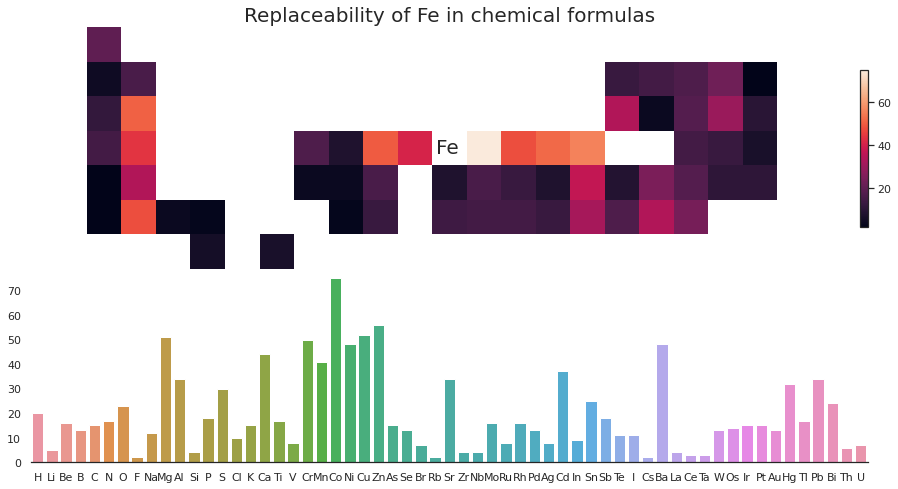

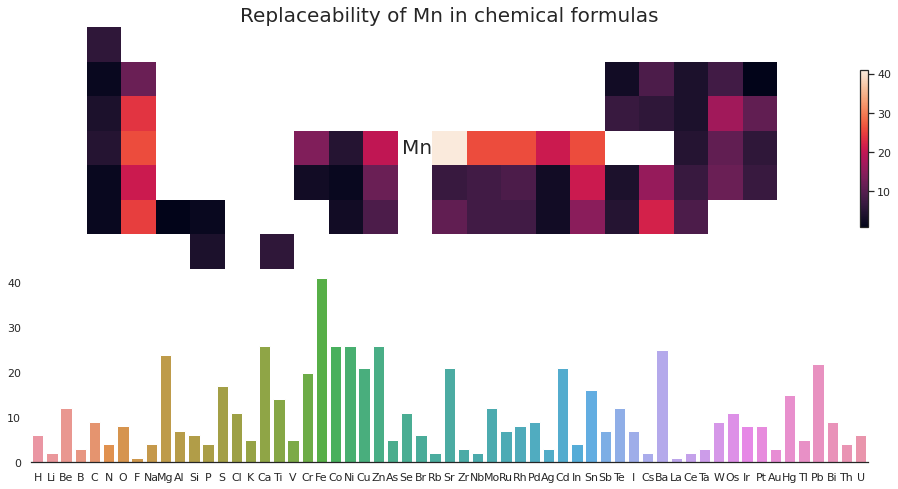

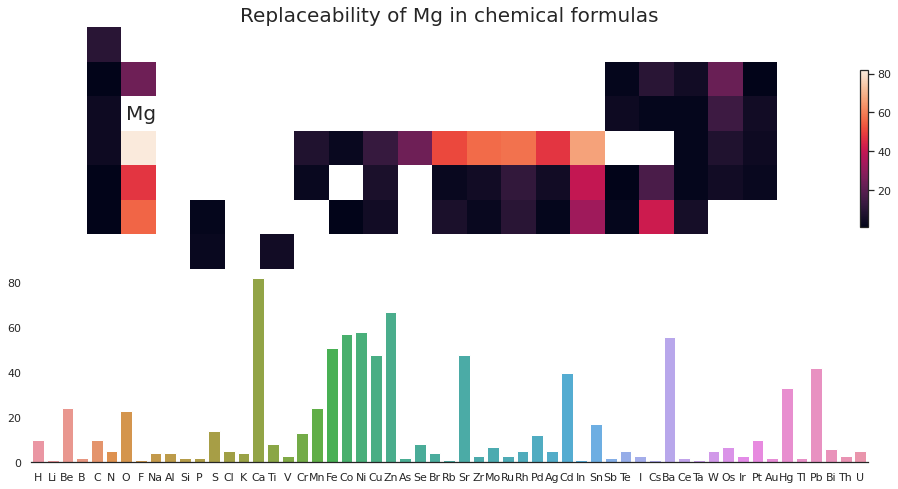

In [17]:
_ = mostSimElems('Fe')
_ = mostSimElems('Mn')
_ = mostSimElems('Mg')

## Another interesting finding (from the Fe plots) is that alkaline earth metals and period 4 transition metals seem to form a separate group.

This *may* be a well known fact, but I actually didn't know this. It is interesting as it raises the questions: 

- Could the PT be organized in such a way that the elements of this "group" are closer to each other? If so, which is better? 
- Why did the PT wasn't conceived this way as opposed to the form we know?

The results from these plots are interesting as they imply that in transition metals the similarities are more horizontal than vertical. 

For instance, 5 and 6 period transition metals are not much brighter than for instance p-block or group 1 elements.

---
### Let's now look at 5 and 6 period transition metals and see if the above observations still hold.

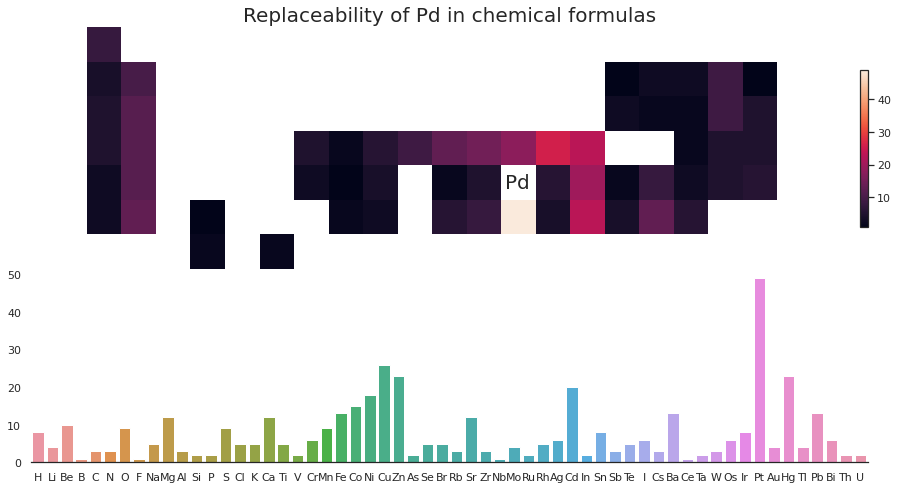

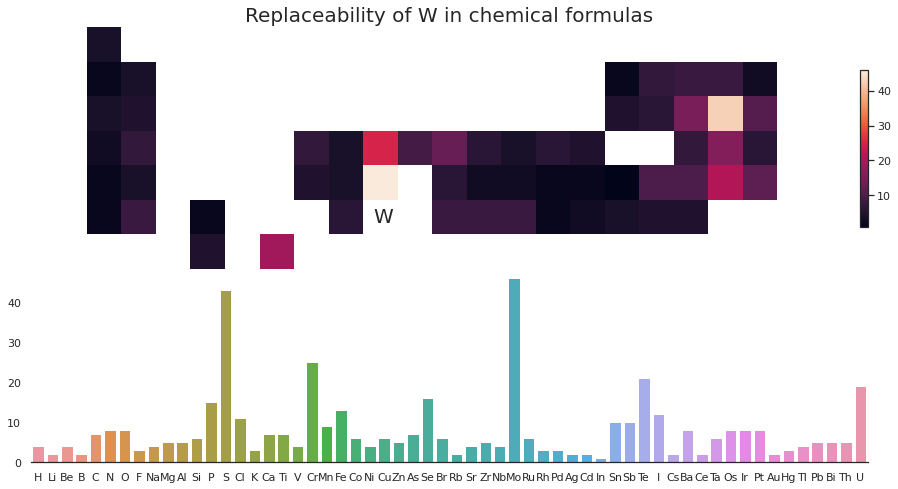

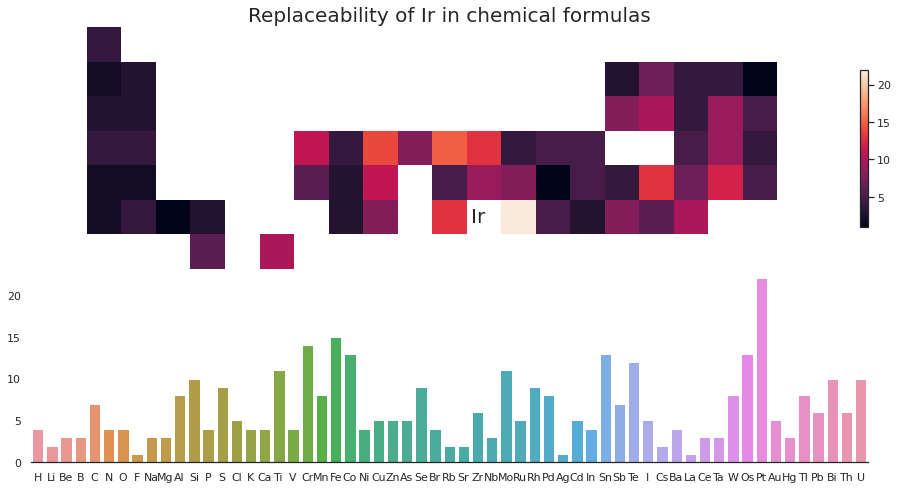

In [18]:
_ = mostSimElems('Pd')
_ = mostSimElems('W')
_ = mostSimElems('Ir')

In this case a similar pattern is actually observed: the brighter elements are those (some) of period 4 + group 12 transition metals in the case of Pd. 

In the case of Pd and W we can also see that vertical similarities are also important: for both of these, the brighter element is that below or above. 

### There is probably some substructure in period 5 and 6 transition metals: here vertical similarities are important as well.

---

All of this is subjected to the inevitable possibility that the chemistry of these elements hadn't been as extensively explored as that of others. In that scenario, some underlying structures are likely to be obfuscated by more visually obvious results due to the undersampling of combinations and/or use of chemical elements at the time.

An example of this would be: there actually exist a vertical structure within all transition metals, however overexploration of the chemistry of period 4 transition metals may have obfuscated such a structure.

### All of this should be properly tested.
---

#### All of the results can be easily visualized in a matrix (similar to a correlation matrix)

In [19]:
def mostSimElems_Data(element):
    """Plot a map and a barplot of the most similar elements for the given element
    based on 'replaceability' in chemical formulas"""

    x,y = rTP[element]
    img = T[T[:,x,y]==1].sum(axis=0).copy()

    mask = img!=0
    with np.errstate(invalid='ignore',divide='ignore'):
        img = img/mask  #Convert zeros to NaNs so image only shows elements
    
    img = img/img[x,y]  # Normalize by number of appearances of element in DS

    df = (pd.DataFrame(img.reshape(1,-1),
                   columns=names,index=[element])
      .dropna(how='all',axis=1))   # Flatten img and drop 'NaN' entries for barplot
    
    return df

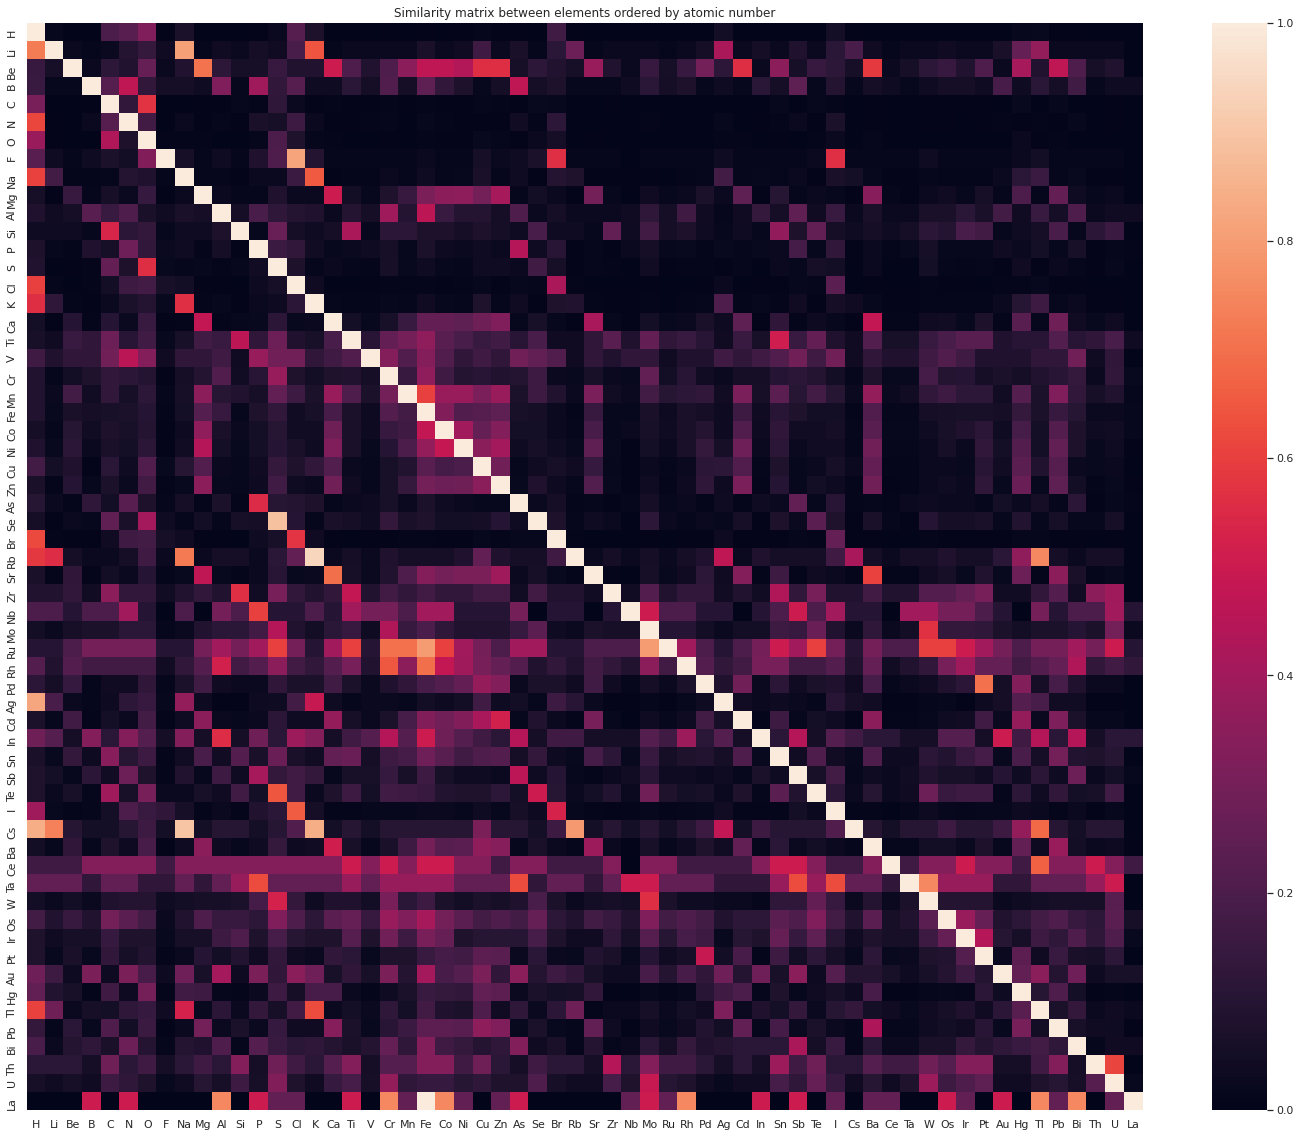

In [20]:
matrix = pd.DataFrame([])

for elem in elemList:
    matrix = pd.concat([matrix,mostSimElems_Data(elem)])
    
matrix = matrix.fillna(0.)
# Use same order as in columns, --> orederd by atomic number
matrix = matrix.loc[matrix.columns,:]  

fig,ax = plt.subplots(figsize=(25,20))
ax.set_title("Similarity matrix between elements ordered by atomic number")
sns.heatmap(matrix,ax=ax)
plt.show()

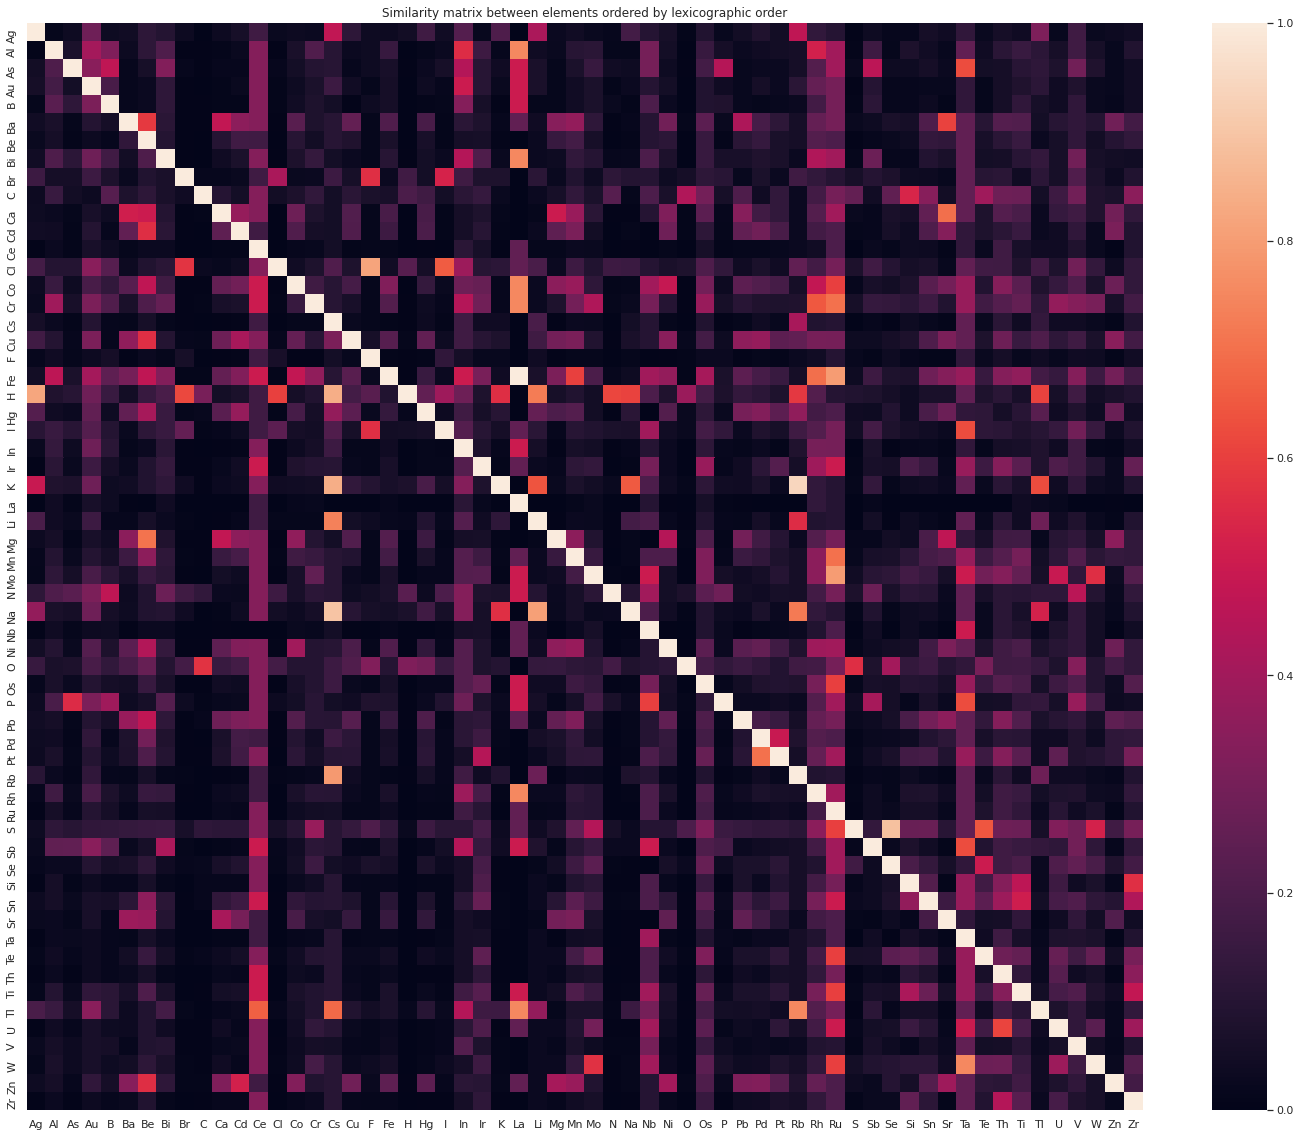

In [21]:
matrix = pd.DataFrame([])

for elem in elemList:
    matrix = pd.concat([matrix,mostSimElems_Data(elem)])
    
matrix = matrix.fillna(0.)
# Use same order as in rows, ordered by lexicographic order (random then)
matrix = matrix.T.loc[matrix.T.columns,:]  

fig,ax = plt.subplots(figsize=(25,20))

ax.set_title("Similarity matrix between elements ordered by lexicographic order")
sns.heatmap(matrix,ax=ax)
plt.show()

### Note: This matrix is not symmetric due to the way the rows were normalized.

Be careful and aware of this fact as this may lead to misunderstandings or wrong conclusions.

In [22]:
#x,y=rTP['Fe']
#x1,y1=rTP['Mg']
#
#mask = (T[:,x,y]==1) & (T[:,x1,y1]==1)
#FeT = T[mask]  # Tables containing Fe
#FeR = r[mask]
#
#N = 3
#fig = plt.figure(figsize=(15,12))
#for i in range(4*N):
#    ax = fig.add_subplot(N,4,i+1)
#    ax.set_title(getFormula(FeR[i],elemList))
#    ax.imshow(FeT[i])
#    ax.axis('off')
#plt.tight_layout()